In [1]:
import pandas as pd
from bs4 import BeautifulSoup
from functools import partial
from pydantic import BaseModel
from pathlib import Path
import plotly.express as px
import tomllib
from typing import List
import json

with open("/Users/marcus/Documents/car_search/data/ads/309743972.txt") as f:
    test_soup = BeautifulSoup(f.read(), "html.parser")

ads_folder = Path.cwd().parent / "data" / "ads"

In [115]:
class Ad(BaseModel):
    model_year: int | None
    model_km: int | None
    price: int | None
    tldr: str | None
    brand: str | None
    model: str | None
    id: int | None
    safety_elements: List[str] | None
    is_leasing: bool | None

/Users/marcus/Documents/car_search/.venv/lib/python3.11/site-packages/pydantic/_internal/_fields.py:160: UserWarning: Field "model_year" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/Users/marcus/Documents/car_search/.venv/lib/python3.11/site-packages/pydantic/_internal/_fields.py:160: UserWarning: Field "model_km" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [116]:
def get_top_row_item(item: str, soup: BeautifulSoup) -> int | None:
    try:
        parent_div = soup.find("div", string=item)

        content_div = parent_div.find_next_sibling("div", class_="u-strong")

        # Extract the text, clean it, and convert to integer
        content_text = content_div.get_text(strip=True)
        content_text = int(content_text.replace("\xa0", "").replace(" km", ""))

        return content_text
    except:
        return None


get_model_year = partial(get_top_row_item, "Modellår")
get_model_km = partial(get_top_row_item, "Kilometer")


def get_tldr(soup) -> str | None:
    try:
        first_h1 = soup.find("h1")
        return first_h1.find_next_sibling("p").get_text(strip=True)
    except:
        return None


def get_price(soup) -> int | None:
    totalpris_label = soup.find("span", string="Totalpris")

    try:
        # First attempt using the provided method
        totalpris_value = totalpris_label.find_next_sibling(
            "span", class_="u-t3"
        ).get_text(strip=True)
        return int(
            totalpris_value.replace("\xa0", "").replace(" kr", "").replace(" ", "")
        )

    except Exception as e:
        try:
            # Alternative method based on the new approach
            script_tag = soup.find("script", {"id": "horseshoe-config"})

            # Parse the JSON content
            json_content = json.loads(script_tag.string)

            # Extract the value of "pris"
            return int(json_content["xandr"]["feed"]["pris"])

        except Exception as e:
            print("Alternative method failed:", e)
            return None


def get_brand_type_id(soup):
    try:
        anchors = soup.find_all("a", id="carSearchLink")

        make_text = anchors[0].get_text(strip=True)
        model_text = anchors[1].get_text(strip=True)
        model_text = model_text.split(" ")[1:]
        model_text = " ".join(model_text)
        model_identifier = anchors[1]["href"].split("model=")[1]

        return make_text, model_text, model_identifier
    except:
        return None, None, None


def get_safty_elements(soup):
    try:
        ul_element = soup.find(
            "ul",
            {
                "aria-label": "Trygghetselementer",
                "class": "tabs__control u-position-relative",
                "role": "tablist",
            },
        )

        # Find all <p> tags with the class 'u-strong' within the located <ul> element
        safety_elements = [
            p.get_text(strip=True) for p in ul_element.select("li p.u-strong")
        ]

        return safety_elements
    except:
        return None


def get_leasing(soup):
    return "Månedspris" in soup.get_text()

In [117]:
files_list = [file for file in ads_folder.iterdir() if file.is_file()]

In [118]:
ad_lst = []
for file in files_list:
    with open(file) as f:
        soup = BeautifulSoup(f.read(), "html.parser")
    try:
        ad = Ad(
            model_year=get_model_year(soup),
            model_km=get_model_km(soup),
            price=get_price(soup),
            tldr=get_tldr(soup),
            brand=get_brand_type_id(soup)[0],
            model=get_brand_type_id(soup)[1],
            id=int(file.stem),
            safety_elements=get_safty_elements(soup),
            is_leasing=get_leasing(soup),
        )

        ad_lst.append(ad)
    except Exception as e:
        print(e)
        print(file)

Alternative method failed: 'NoneType' object is not subscriptable
Alternative method failed: 'NoneType' object is not subscriptable
Alternative method failed: 'NoneType' object is not subscriptable
Alternative method failed: 'NoneType' object is not subscriptable
Alternative method failed: 'NoneType' object is not subscriptable
Alternative method failed: 'NoneType' object is not subscriptable
Alternative method failed: 'NoneType' object is not subscriptable
Alternative method failed: 'NoneType' object is not subscriptable
Alternative method failed: 'NoneType' object is not subscriptable
Alternative method failed: 'NoneType' object is not subscriptable


In [137]:
ads_df = pd.DataFrame([ad.model_dump() for ad in ad_lst])

In [138]:
ads_df["model"].unique()

array(['ID.4 GTX', 'Model 3', 'C-HR', 'Model S', 'ID.4', 'Model X',
       'Corolla', 'Prius', 'Prius Plug-in Hybrid'], dtype=object)

/Users/marcus/Documents/car_search/.venv/lib/python3.11/site-packages/seaborn/regression.py:261: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)
/Users/marcus/Documents/car_search/.venv/lib/python3.11/site-packages/seaborn/regression.py:261: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)
/Users/marcus/Documents/car_search/.venv/lib/python3.11/site-packages/seaborn/regression.py:261: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)
/Users/marcus/Documents/car_search/.venv/lib/python3.11/site-packages/seaborn/regression.py:261: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)
/Users/marcus/Documents/car_search/.venv/lib/python3.11/site-packages/seaborn/regression.py:261: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)
/Users/marcus/D

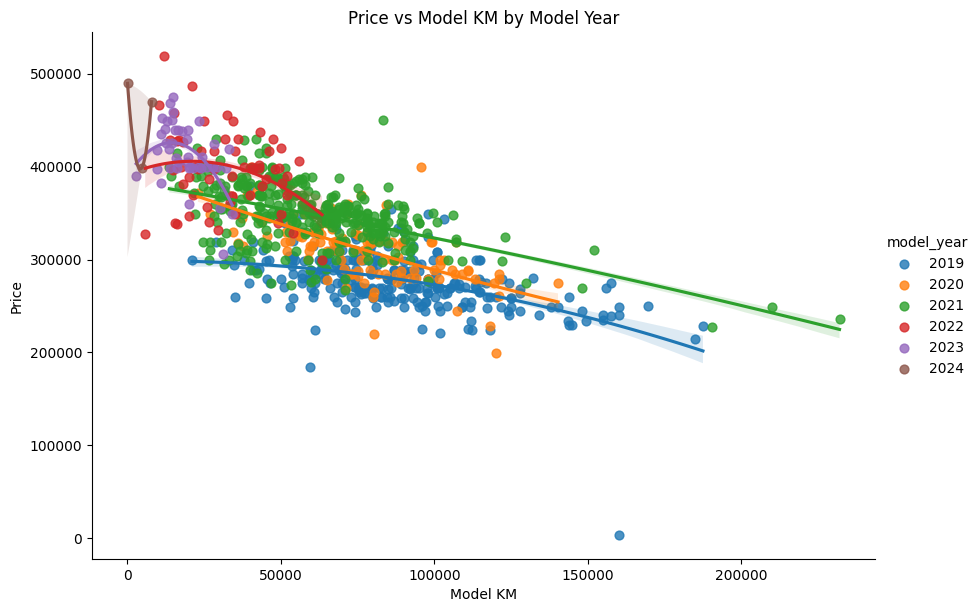

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming touring_df is your dataframe
# Sample data
# touring_df = pd.DataFrame({
#     'model_km': [...],
#     'price': [...],
#     'model_year': [...]
# })

# Create a scatter plot with non-linear regression lines for each year
sns.lmplot(
    data=ads_df[(ads_df["model"] == "Model 3") & (ads_df["price"] < 1000000)],
    x="model_km",
    y="price",
    hue="model_year",
    ci=50,  # Show 95% confidence interval
    height=6,
    aspect=1.5,
    order=2,  # Fit a second-order polynomial regression
    scatter_kws={"s": 40},  # Reduce the size of the dots
)

# Set the title and labels
plt.title("Price vs Model KM by Model Year")
plt.xlabel("Model KM")
plt.ylabel("Price")

# Show the plot
plt.show()

In [123]:
with open("/Users/marcus/Documents/car_search/src/config.toml", "rb") as f:
    config = tomllib.load(f)
    car_codes = config["car_codes"]

In [136]:
ads_df.dtypes

model_year                  Int64
model_km                    Int64
price                       Int64
tldr               string[python]
brand              string[python]
model              string[python]
id                          Int64
safety_elements            object
is_leasing                boolean
dtype: object

In [141]:
set(ads_df["safety_elements"].tolist())

TypeError: unhashable type: 'list'

In [143]:
flattened_list = [
    item for sublist in ads_df["safety_elements"].dropna() for item in sublist
]

# Get unique elements
unique_elements = list(set(flattened_list))

In [144]:
unique_elements

['Service',
 'Medlem',
 'Bruktbilgaranti',
 'Bytterett',
 'Programbil',
 'Garanti',
 'Tilstand']

In [2]:
ads_df = pd.read_parquet("/Users/marcus/Documents/car_search/data/ads.parquet")

In [13]:
for index, row in ads_df.iterrows():
    if row["tldr"]:
        if "Touring" in row["tldr"]:
            ads_df.at[index, "model"] = "Corolla Touring"

In [14]:
ads_df.dropna(subset=["tldr"])[
    ads_df.dropna(subset=["tldr"])["tldr"].str.contains("Touring")
]

,model_year,model_km,price,tldr,brand,model,id,link,safety_elements,is_leasing
17,2022,9123.0,359000.0,"1,8 Hybrid Touring Sports Active Tech Lav kilo...",Toyota,Corolla Touring,333163476,https://www.finn.no/car/used/ad.html?finnkode=...,"[Garanti, Service, Bytterett, Medlem]",False
77,2021,38000.0,274000.0,"1,8 Hybrid Touring Sports Active Tech",Toyota,Corolla Touring,343980719,https://www.finn.no/car/used/ad.html?finnkode=...,"[Garanti, Service, Bytterett, Medlem]",False
90,2020,70400.0,239000.0,"1,8 Hybrid Touring Sports e-CVT Active Tech KA...",Toyota,Corolla Touring,347920925,https://www.finn.no/car/used/ad.html?finnkode=...,"[Garanti, Tilstand, Service, Bytterett, Medlem...",False
173,2019,74049.0,249000.0,"1,8 Hybrid Touring Sports e-CVT Active Tech --...",Toyota,Corolla Touring,354126408,https://www.finn.no/car/used/ad.html?finnkode=...,"[Garanti, Service, Bytterett, Medlem, Programbil]",False
177,2020,87000.0,194305.0,"1,8 Hybrid Touring Sports e-CVT Active Tech",Toyota,Corolla Touring,346635358,https://www.finn.no/car/used/ad.html?finnkode=...,[Service],False
...,...,...,...,...,...,...,...,...,...,...
3975,2019,33270.0,259000.0,"1,8 Hybrid Touring Sports e-CVT Active Tech",Toyota,Corolla Touring,352936481,https://www.finn.no/car/used/ad.html?finnkode=...,"[Service, Medlem]",False
3982,2020,79000.0,249000.0,"1,8 Hybrid Touring Sports e-CVT Active Tech KA...",Toyota,Corolla Touring,348822951,https://www.finn.no/car/used/ad.html?finnkode=...,"[Garanti, Tilstand, Service, Bytterett, Medlem...",False
3996,2022,24464.0,319000.0,"1,8 Hybrid Touring Sports Active Tech",Toyota,Corolla Touring,340960213,https://www.finn.no/car/used/ad.html?finnkode=...,"[Garanti, Service, Medlem]",False
4001,2021,50293.0,299000.0,"1,8 Hybrid Touring Sports Active Tech kampanje...",Toyota,Corolla Touring,337212242,https://www.finn.no/car/used/ad.html?finnkode=...,"[Garanti, Medlem]",False


In [7]:
print(str("hello"))

hello
